In [1]:
# classify Reuters newswires into 46 mutually exclusive topics via multiclass classification
# each data point should be classified into only one category, the problem is more specifically: single-label, multiclass classification
# if each data point could belong to multiple categories: multi-label, multiclass classification

In [2]:
# Reuters dataset - a set of short newswires and their topics published in 1986
# there are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

/Users/timhou/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 750M (0000:01:00.0)


In [3]:
# 8982 training examples
len(train_data)

8982

In [4]:
# 2246 test examples
len(test_data)

2246

In [5]:
# each example is a list of integers (word indices)
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [6]:
# decode newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(v, k) for (k, v) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i-3, "?") for i in train_data[0]])
decoded_newswire

u'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [7]:
# label associated with an example is an integer between 0 and 45
train_labels[0]

3

In [8]:
# vectorize data
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
# vectorize label: one-hot encoding (categorical encoding)
# other option: label list as an integer tensor
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)
one_hot_train_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
# built-in one-hot encoding
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
one_hot_train_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
# now the dimensionality of the output space is much larger (2 -> 46 num of output classes)
# previously, we were using 16-dimensional intermediate layers, but that might be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information
# if one layer drops some information relevant to the classification problem, this information can never be recovered by later layers
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [12]:
# end the dense layer with size 46 which results in each input sample outputted to a 46-dimensional vector (each entry in this vector will encode a different output class)
# last layer uses a softmax activation yielding a probability distribution output over 46 different output classes (where output[i] is the probability that the sample belongs to class i)
# the 46 scores will sum to 1
# best loss function for this case: categorical_crossentropy
# categorical crossentropy - measures the distance between two probability distributions
# by minimizing the distance between these two distributions, you train the network to output something as close as possible to the true labels
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# validating approach by setting apart 1000 samples in the training data as validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

print x_val.shape
print partial_x_train.shape
print 1000/7982. * 100

(1000, 10000)
(7982, 10000)
12.528188424


In [14]:
# train the network for 20 epochs
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 109us/step - loss: 2.6758 - acc: 0.4853 - val_loss: 1.7627 - val_acc: 0.6110
Epoch 2/20
7982/7982 [==============================] - 1s 71us/step - loss: 1.4396 - acc: 0.6875 - val_loss: 1.2972 - val_acc: 0.7130
Epoch 3/20
7982/7982 [==============================] - 1s 73us/step - loss: 1.0537 - acc: 0.7701 - val_loss: 1.1246 - val_acc: 0.7580
Epoch 4/20
7982/7982 [==============================] - 1s 71us/step - loss: 0.8361 - acc: 0.8236 - val_loss: 1.0219 - val_acc: 0.7720
Epoch 5/20
7982/7982 [==============================] - 1s 70us/step - loss: 0.6717 - acc: 0.8593 - val_loss: 0.9597 - val_acc: 0.7900
Epoch 6/20
7982/7982 [==============================] - 1s 68us/step - loss: 0.5423 - acc: 0.8891 - val_loss: 0.9056 - val_acc: 0.8140
Epoch 7/20
7982/7982 [==============================] - 0s 62us/step - loss: 0.4448 - acc: 0.9089 - val_loss: 0.8866 - val_acc: 0.8070
Epoch 

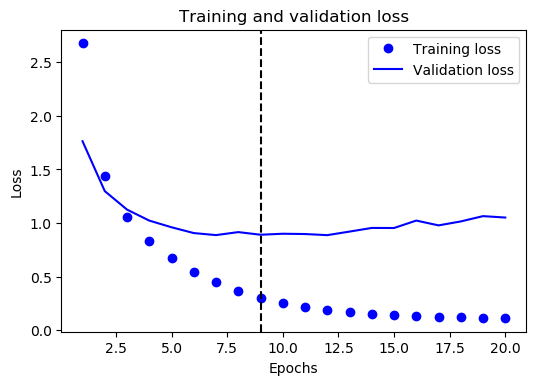

In [27]:
# plotting the training and validation loss
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axvline(9.0, color='k', linestyle='--')
# plt.axvline(np.argmin(val_loss), color='k', linestyle='--')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

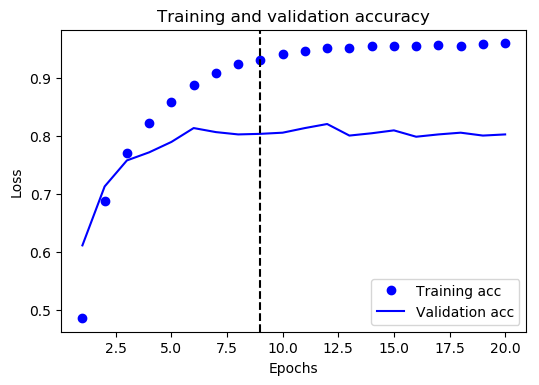

In [28]:
# plotting the training and validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.axvline(9.0, color='k', linestyle='--')
# plt.axvline(np.argmax(val_acc), color='k', linestyle='--')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [29]:
# network begins to overfit after 9 epochs
# now, train a new network from scratch for nine epochs and then evaluate it on the test set
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 79us/step - loss: 2.6183 - acc: 0.5352 - val_loss: 1.7253 - val_acc: 0.6510
Epoch 2/9
7982/7982 [==============================] - 1s 70us/step - loss: 1.4119 - acc: 0.7040 - val_loss: 1.2858 - val_acc: 0.7100
Epoch 3/9
7982/7982 [==============================] - 1s 74us/step - loss: 1.0429 - acc: 0.7710 - val_loss: 1.1299 - val_acc: 0.7500
Epoch 4/9
7982/7982 [==============================] - 1s 73us/step - loss: 0.8248 - acc: 0.8230 - val_loss: 1.0383 - val_acc: 0.7640
Epoch 5/9
7982/7982 [==============================] - 1s 71us/step - loss: 0.6634 - acc: 0.8614 - val_loss: 0.9655 - val_acc: 0.7930
Epoch 6/9
7982/7982 [==============================] - 1s 71us/step - loss: 0.5318 - acc: 0.8886 - val_loss: 0.9048 - val_acc: 0.8090
Epoch 7/9
7982/7982 [==============================] - 1s 72us/step - loss: 0.4303 - acc: 0.9097 - val_loss: 0.8908 - val_acc: 0.8120
Epoch 8/9
7982

In [30]:
# this approach reaches an accuracy of ~80%
results

[0.9883354833268313, 0.7831700801955518]

In [31]:
# with a balanced binary classification problem, the accuracy reached by a purely classifier would be 50%
# in this case, it's close to 18%, so the results seem pretty good, at least when compare to a random baseline
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.182546749777382

In [32]:
# generating predictions on new data
# verify predict method of the model returns a probability distribution over all 46 topics
predictions = model.predict(x_test)
# each entry in predictions is a vector of length 46:
print predictions[0].shape

(46,)


In [33]:
# coefficients in the vector sum to 1:
np.sum(predictions[0])

0.9999998

In [34]:
# largest entry is the predicted class (the class with the highest probability)
np.argmax(predictions[0])

3

In [35]:
# different way to handle the labels and the loss
# encoding method: encode labels as an integer tensor
y_train = np.array(train_labels)
x_train = np.array(test_labels)

In [36]:
# this approach changes the choice of the loss function
# before: categorical_crossentropy (expects labels to follow categorical encoding)
# now: with integer labels, use sparse_categorical_crossentropy
# this new loss function is still mathematically the same as categorical_crossentropy (different interface)
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [37]:
# importance of having sufficiently large intermediate layers
# because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 hidden units
# try intermediate layers with 4-dimensionals to see what happens

In [38]:
# a model with an information bottleneck
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 82us/step - loss: 3.1632 - acc: 0.1803 - val_loss: 2.4899 - val_acc: 0.3940
Epoch 2/20
7982/7982 [==============================] - 1s 79us/step - loss: 1.9259 - acc: 0.5234 - val_loss: 1.6015 - val_acc: 0.6550
Epoch 3/20
7982/7982 [==============================] - 1s 76us/step - loss: 1.3332 - acc: 0.6947 - val_loss: 1.3909 - val_acc: 0.6770
Epoch 4/20
7982/7982 [==============================] - 1s 79us/step - loss: 1.1266 - acc: 0.7171 - val_loss: 1.3436 - val_acc: 0.6760
Epoch 5/20
7982/7982 [==============================] - 1s 80us/step - loss: 1.0021 - acc: 0.7296 - val_loss: 1.3096 - val_acc: 0.6860
Epoch 6/20
7982/7982 [==============================] - 1s 66us/step - loss: 0.9032 - acc: 0.7509 - val_loss: 1.3416 - val_acc: 0.6990
Epoch 7/20
7982/7982 [==============================] - 1s 73us/step - loss: 0.8196 - acc: 0.7899 - val_loss: 1.3384 - val_acc: 0.7140
Epoch 8

In [39]:
# the network now peaks at ~71% validation accuracy (8% absolute drop)
# this drop is mostly due to the fact that you're trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional
# the network is able to cram most of the necessary information into these 8-dimensional representations, but not all of it

In [40]:
# future experiments
# try using larger or smaller layers: 32 units / 128 units
# try single hidden layers or three hidden layers

In [41]:
# take aways from this example:
# If you’re trying to classify data points among N classes, your network should end with a Dense layer of size N.
# In a single-label, multiclass classification problem, your network should end with a softmax activation so that it will output a probability distribution over the N output classes.
# Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network and the true distribution of the targets.
# There are two ways to handle labels in multiclass classification:
# 1. Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function
# 2. Encoding the labels as integers and using the sparse_categorical_crossentropy loss function
# If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small.